In [4]:
# Importo librerias necesarias
import warnings
warnings.filterwarnings("ignore")
import numpy as np # librería para poder usar arreglos
import pandas as pd # librería para poder usad DataFrames (tablas)
import plotly.express as px
import matplotlib.pyplot as plt # to plot
import seaborn as sns # to plot
import sklearn # librería para poder usar modelos de machine learning
import os
import urllib.request
import json

In [5]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import sklearn.decomposition as sk # to compute PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression


In [6]:
def get_data():
    """
    Funcion para obtener los datos del archivo covid.csv
    """

    dataSet = pd.read_csv("covid.csv", header=0)
    dataSet.set_index('date', inplace=True)
    dataSet.index = pd.to_datetime(dataSet.index,format='%d/%m/%y',errors='ignore')

    return dataSet

def infoData(dataSet):
    """
    Funcion para obtener datos generales
    """

    print(dataSet.head(10))
    print("")
    print(dataSet.info())
    print("")
    print(dataSet.isnull().sum())
    print("")

In [7]:
data = get_data()
infoData(data)


            AGUASCALIENTES  BAJA CALIFORNIA  ...  ZACATECAS  Nacional
date                                         ...                     
2020-02-26               0                0  ...          0         0
2020-02-27               0                0  ...          0         4
2020-02-28               0                0  ...          0         2
2020-02-29               0                0  ...          0         2
2020-03-01               0                0  ...          0         2
2020-03-02               0                0  ...          0         5
2020-03-03               0                0  ...          1         9
2020-03-04               0                0  ...          0        10
2020-03-05               0                0  ...          1        11
2020-03-06               0                0  ...          0         6

[10 rows x 33 columns]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1215 entries, 2020-02-26 to 2023-06-24
Data columns (total 33 columns):
 #   Colum

In [8]:
#def map(dataSet):
#    """
#    Funcion para visualizar la evolución de casos de Covid-19 en los estados de México usando un mapa de calor interactivo con plotly.
#    """
#
#
    # Asegurarse de que el índice es de tipo fecha y resetearlo para tenerlo como columna
#    df = dataSet.copy()
 #   df = df.reset_index()
#    df.rename(columns={'date': 'Fecha'}, inplace=True)

    # Lista de estados (todas las columnas excepto 'Fecha' y 'Nacional')
#    estados = [col for col in df.columns if col not in ['Fecha', 'Nacional']]

    # Convertir el dataframe a formato largo para plotly
 #   df_long = df.melt(id_vars=['Fecha'], value_vars=estados, var_name='Estado', value_name='Casos')

    # Cargar geojson de México (estados)
    # Puedes descargar un geojson de los estados de México, por ejemplo desde: https://raw.githubusercontent.com/angelnmara/geojson/master/mexicoHigh.json
    # Aquí se asume que el archivo se llama 'mexico_estados.geojson' y está en el mismo directorio
  #  with open('mexico_estados.geojson', 'r', encoding='utf-8') as f:
   #     mexico_geojson = json.load(f)

    # Crear el mapa animado
    #fig = px.choropleth(
     #   df_long,
      #  geojson=mexico_geojson,
       # locations='Estado',
        #color='Casos',
     #   animation_frame='Fecha',
#        featureidkey='properties.NOM_ENT',  # Depende del geojson, puede ser 'properties.NOM_ENT' o 'properties.name'
 #       color_continuous_scale='Reds',
  #      scope='world',
   #     labels={'Casos': 'Casos normalizados'},
    #    title='Evolución de casos de Covid-19 por estado en México'
    #)
    #fig.update_geos(fitbounds="locations", visible=False)
    #fig.update_layout(margin={"r":0,"t":40,"l":0,"b":0})
    #fig.show()

In [9]:
# %pip show nbformat

In [10]:
#Running `%pip install nbformat` in a Jupyter notebook should install the `nbformat` package. However, if you still see the error `ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed`, possible reasons include:

#1. **Kernel Restart Needed:** After installing a new package, you often need to restart the Jupyter kernel for the changes to take effect.
#2. **Multiple Python Environments:** The notebook kernel might be using a different Python environment than the one where `nbformat` was installed.
#3. **Installation Failed:** The installation may have failed silently or with a warning.

#**How to fix:**
#- Run `%pip show nbformat` in a cell to check if it is installed and its version.
#- If not installed, run `%pip install nbformat --upgrade` and then restart the kernel.
#- Make sure your notebook is running in the same environment where you installed `nbformat`.

#If the problem persists, check your Jupyter server logs for more details.
#map(data)

In [11]:
def preprocess_data(dataSet):
    """
    Funcion para el preprocesamiento de datos
    """

    local_dataSet = dataSet.dropna()
    columns_list = dataSet.columns.tolist()
    min_max_scaler = preprocessing.MinMaxScaler()
    min_max_scaler.fit(local_dataSet)
    new_dataSet = min_max_scaler.transform(local_dataSet)

    new_dataSet = pd.DataFrame(np.round(new_dataSet,4), columns=columns_list)
    new_dataSet.index = local_dataSet.index

    return new_dataSet

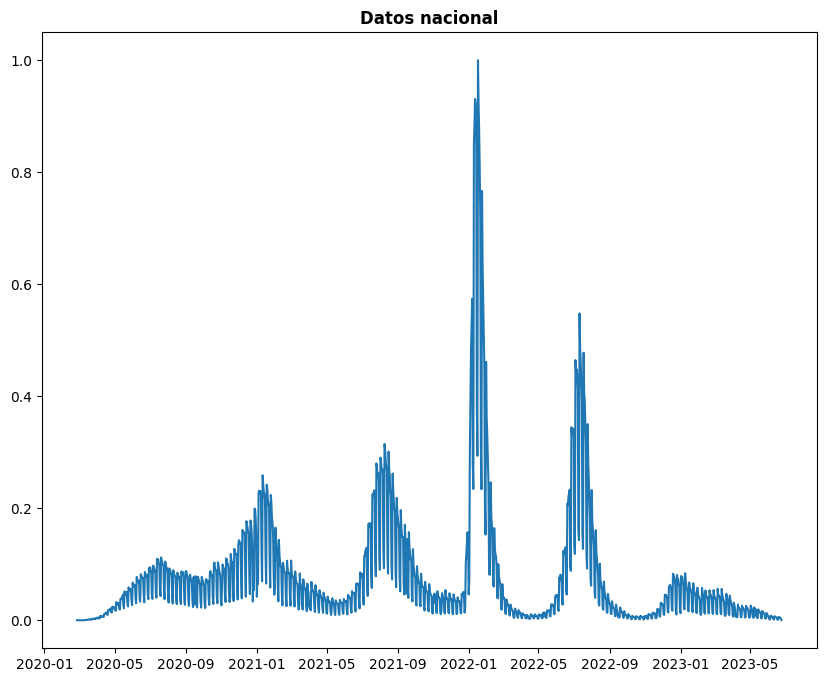

In [12]:
preprocessData = preprocess_data(data)

plt.figure(figsize=(10, 8))
plt.plot(preprocessData['Nacional'])
plt.title('Datos nacional', fontweight='bold')
plt.show()

In [13]:
def pca_Transformation(dataSet):
    features = dataSet
    features = features.drop(['Nacional'], axis=1)

    # principal components analysis
    pca = sk.PCA(n_components=3)
    principalComponents = pca.fit_transform(features)
    principalComp = pd.DataFrame(data = principalComponents,
                                 columns = ['P. Comp. 1', 'P. Comp. 2', 'P. Comp. 3'])
    principalComp.set_index(dataSet.index,inplace = True, drop=True)
    principalComp['Nacional'] = dataSet['Nacional']
    cols = principalComp.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    principalComp = principalComp[cols]

    print("==========================================================")
    print("                 PCA ANALYSIS")
    print("----------------------------------------------------------")
    print(principalComp)
    print("\n")

    varRatio = (pca.explained_variance_ratio_)*100
    data = {'P. Comp. 1':varRatio[0],'P. Comp. 2':varRatio[1],'P. Comp. 3':varRatio[2]}
    dfVar = pd.DataFrame(data, index=['Exp Var Ratio %'])
    print(dfVar)
    print("\n")

    return principalComp

In [14]:
pcaData = pca_Transformation(preprocessData)
pcaData.head(1215)

                 PCA ANALYSIS
----------------------------------------------------------
            Nacional  P. Comp. 1  P. Comp. 2  P. Comp. 3
date                                                    
2020-02-26    0.0000   -0.420984   -0.025472   -0.013954
2020-02-27    0.0000   -0.420786   -0.025421   -0.013903
2020-02-28    0.0000   -0.420896   -0.025544   -0.013894
2020-02-29    0.0000   -0.420792   -0.025320   -0.014072
2020-03-01    0.0000   -0.420784   -0.025356   -0.013891
...              ...         ...         ...         ...
2023-06-20    0.0055   -0.385418   -0.023980   -0.031617
2023-06-21    0.0050   -0.389817   -0.025970   -0.026036
2023-06-22    0.0048   -0.394643   -0.029628   -0.022447
2023-06-23    0.0026   -0.401546   -0.021571   -0.028535
2023-06-24    0.0002   -0.419864   -0.024882   -0.014331

[1215 rows x 4 columns]


                 P. Comp. 1  P. Comp. 2  P. Comp. 3
Exp Var Ratio %   81.101835    5.824434    3.614026




,Nacional,P. Comp. 1,P. Comp. 2,P. Comp. 3
date,,,,
2020-02-26,0.0000,-0.420984,-0.025472,-0.013954
2020-02-27,0.0000,-0.420786,-0.025421,-0.013903
2020-02-28,0.0000,-0.420896,-0.025544,-0.013894
2020-02-29,0.0000,-0.420792,-0.025320,-0.014072
2020-03-01,0.0000,-0.420784,-0.025356,-0.013891
...,...,...,...,...
2023-06-20,0.0055,-0.385418,-0.023980,-0.031617
2023-06-21,0.0050,-0.389817,-0.025970,-0.026036
2023-06-22,0.0048,-0.394643,-0.029628,-0.022447


In [15]:
train_data, test_data = train_test_split(pcaData, test_size=0.25, shuffle=False)
print(train_data.head(1215))
print("")
print(len(train_data))
print("")
print(test_data.head(1215))
print("")
print(len(test_data))

            Nacional  P. Comp. 1  P. Comp. 2  P. Comp. 3
date                                                    
2020-02-26    0.0000   -0.420984   -0.025472   -0.013954
2020-02-27    0.0000   -0.420786   -0.025421   -0.013903
2020-02-28    0.0000   -0.420896   -0.025544   -0.013894
2020-02-29    0.0000   -0.420792   -0.025320   -0.014072
2020-03-01    0.0000   -0.420784   -0.025356   -0.013891
...              ...         ...         ...         ...
2022-08-20    0.0210   -0.287385    0.002451    0.002460
2022-08-21    0.0187   -0.293690    0.000125    0.009103
2022-08-22    0.0691   -0.015549    0.005202    0.060701
2022-08-23    0.0507   -0.102404    0.010890    0.055541
2022-08-24    0.0462   -0.132828    0.019228    0.046232

[911 rows x 4 columns]

911

            Nacional  P. Comp. 1  P. Comp. 2  P. Comp. 3
date                                                    
2022-08-25    0.0404   -0.171591    0.015264    0.020806
2022-08-26    0.0362   -0.204175    0.005791    0.015538
2

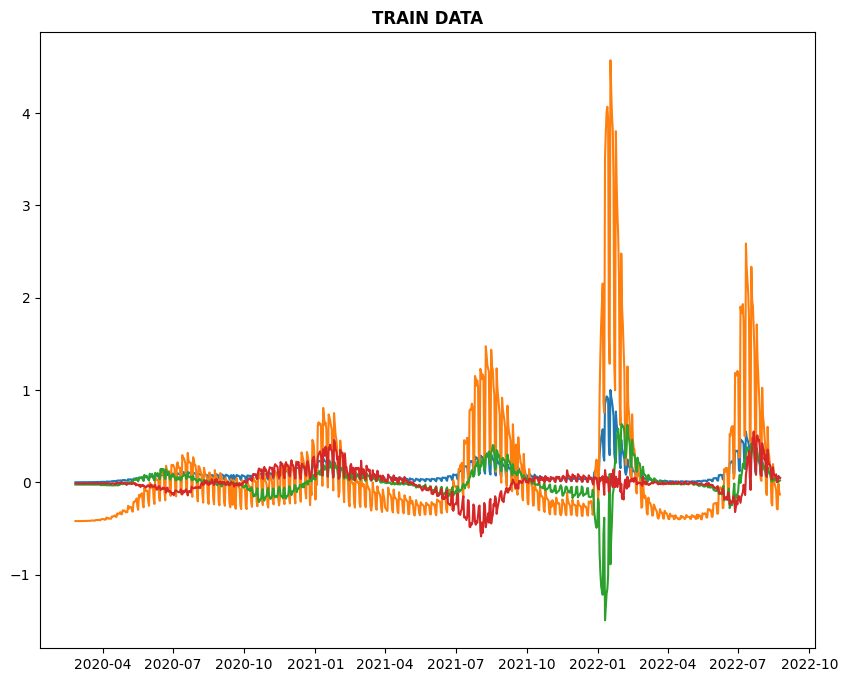

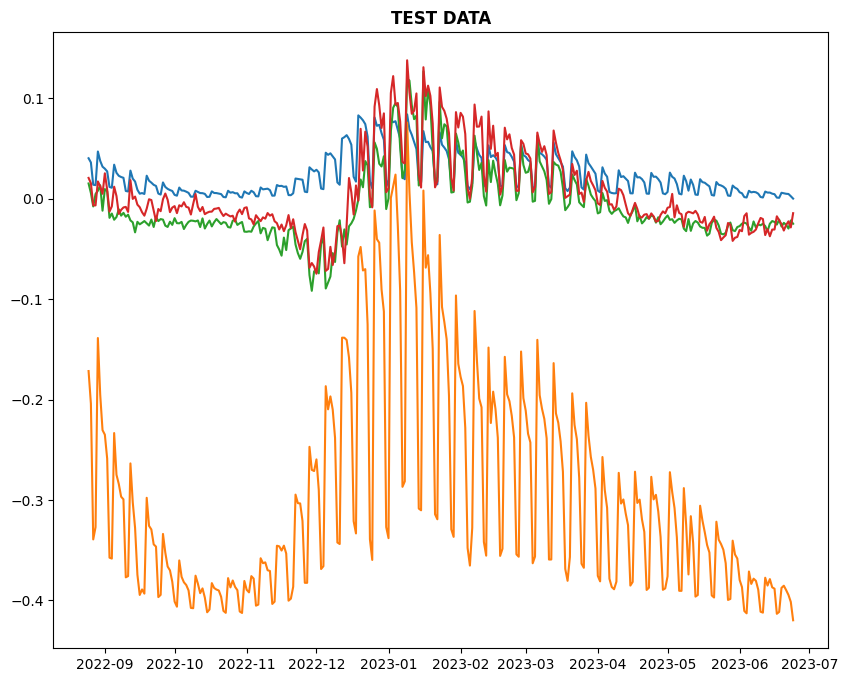

In [16]:
plt.figure(figsize=(10, 8))
plt.plot(train_data)
plt.title('TRAIN DATA', fontweight='bold')
plt.show()

plt.figure(figsize=(10, 8))
plt.plot(test_data)
plt.title('TEST DATA', fontweight='bold')
plt.show()

Modelado del PCA

In [17]:
# === Definición de variables (X e Y) anteriormente realizada ===
# X_train = train_data.iloc[:, 0:3]
# Y_train = train_data.iloc[:, [-1]]

# X_test = test_data.iloc[:, 0:3]
# Y_test = test_data.iloc[:, [-1]]

# === Definición de variables (X e Y) Train y Test===
X_train = train_data[['P. Comp. 1', 'P. Comp. 2', 'P. Comp. 3']]  # Características
Y_train = train_data[['Nacional']]  # Objetivo
X_test = test_data[['P. Comp. 1', 'P. Comp. 2', 'P. Comp. 3']]  # Características
Y_test = test_data[['Nacional']]  # Objetivo

In [18]:
# Decision Tree Regressor
dt_regr = DecisionTreeRegressor()
param_search_dt_regr = {
    'criterion': ['squared_error', 'absolute_error', 'poisson'], #Puedo añadir 'friedman_mse',
    'max_depth': [3, 5, 7, 9, 15, 20, None]
}
# Puedo probar con 'min_samples_split': [2, 5, 10],
# Puedo probar con 'min_samples_leaf': [1, 2, 4]

# Utilizo GridSearchCV para encontrar los mejores parámetros
# Definir X (característica) y y (objetivo)
X = train_data[['P. Comp. 1', 'P. Comp. 2', 'P. Comp. 3']]
y = train_data[['Nacional']]

grid_search_dt = GridSearchCV(estimator=dt_regr, param_grid=param_search_dt_regr, n_jobs=-1, cv=5, verbose=1)
grid_search_dt.fit(X, y)  # Entreno el modelo con los componentes principales como característica y la columna 'Nacional' como objetivo
best_params_dt = grid_search_dt.best_params_

print("==========================================================")
print("Mejores parámetros para Decision Tree Regressor:")
print(best_params_dt)
print("----------------------------------------------------------")

Fitting 5 folds for each of 21 candidates, totalling 105 fits
Mejores parámetros para Decision Tree Regressor:
{'criterion': 'absolute_error', 'max_depth': 15}
----------------------------------------------------------


In [19]:
dt_optimo = grid_search_dt.best_estimator_
# === MultiOutputRegressor para predecir los 3 componentes principales ===
dt_optimo.fit(X_train, Y_train)

# === Predicciones ===
train_pred_dt = dt_optimo.predict(X_train)  # Predecir 'Nacional' para train
test_pred_dt = dt_optimo.predict(X_test)    # Predecir 'Nacional' para test

# === Convertir a DataFrames para análisis ===
pred_train_df_dt = pd.DataFrame(train_pred_dt, columns=["Nacional"], index=X_train.index)
pred_test_df_dt = pd.DataFrame(test_pred_dt, columns=["Nacional"], index=X_test.index)

pred_train_df_dt.columns = ["Nacional"]
pred_test_df_dt.columns = ["Nacional"]

def evaluacion_metricas(true_df, pred_df):
    """
    Calculate various regression metrics comparing true and predicted values.
    
    Parameters:
    -----------
    true_df : pandas.DataFrame
        DataFrame containing actual values with 'Nacional' column
    pred_df : pandas.DataFrame
        DataFrame containing predicted values with 'Nacional' column
    
    Returns:
    --------
    pandas.DataFrame
        DataFrame containing calculated metrics
    """
    # Initialize metrics dictionary
    metrics_dict = {}
    
    # Get sample size and number of predictors
    n = len(true_df["Nacional"])
    k = 1  # number of predictors
    
    # Calculate basic error metrics
    mse = mean_squared_error(true_df["Nacional"], pred_df["Nacional"])
    mae = mean_absolute_error(true_df["Nacional"], pred_df["Nacional"])
    mape = mean_absolute_percentage_error(true_df["Nacional"], pred_df["Nacional"])
    r2 = r2_score(true_df["Nacional"], pred_df["Nacional"])
    rmse = mse ** 0.5
    
    # Calculate information criteria
    if mse > 0:
        log_likelihood = -n / 2 * np.log(2 * np.pi * mse) - n / 2
        aic = 2 * k - 2 * log_likelihood
        bic = np.log(n) * k - 2 * log_likelihood
    else:
        aic = np.nan
        bic = np.nan
    
    # Calculate Amemiya's Prediction Criterion
    apc = (1 + (k / n)) * mse
    
    # Store all metrics in dictionary
    metrics_dict["Nacional"] = {
        "MSE": mse,
        "MAE": mae,
        "MAPE": mape,
        "R2": r2,
        "RMSE": rmse,
        "AIC": aic,
        "APC": apc,
        "BIC": bic
    }
    
    return pd.DataFrame(metrics_dict).T
# Usar train_data[["Nacional"]] y test_data[["Nacional"]] para las métricas
train_metrics_dt = evaluacion_metricas(train_data[["Nacional"]], pred_train_df_dt)
test_metrics_dt = evaluacion_metricas(test_data[["Nacional"]], pred_test_df_dt)

print("\n Métrica - Train Nacional:")
print(train_metrics_dt)
print("\n Métrica - Test Nacional:")
print(test_metrics_dt)


 Métrica - Train Nacional:
                   MSE       MAE  ...           APC           BIC
Nacional  2.871021e-08  0.000021  ...  2.874172e-08 -13228.317364

[1 rows x 8 columns]

 Métrica - Test Nacional:
               MSE       MAE      MAPE  ...          AIC       APC          BIC
Nacional  0.000034  0.003421  0.172458  ... -2264.717076  0.000034 -2261.000048

[1 rows x 8 columns]


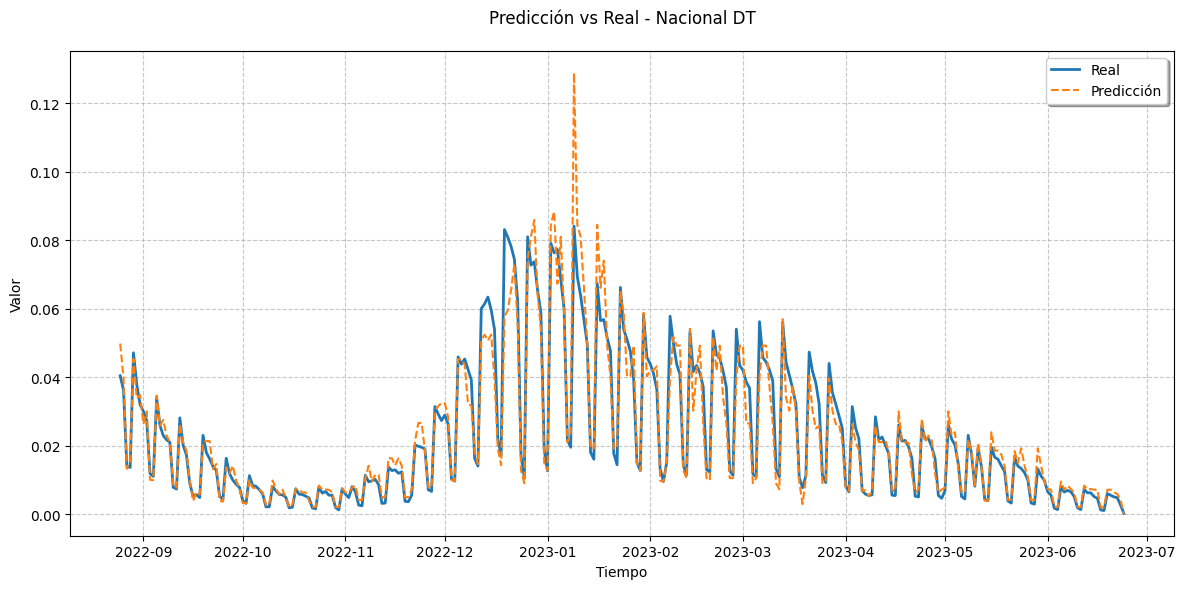

In [20]:
#Grafica de la predicción vs real DT
plt.figure(figsize=(12, 6))  
plt.plot(Y_test.index, Y_test.values, label="Real", linewidth=2)  
plt.plot(pred_test_df_dt.index, pred_test_df_dt.values, label="Predicción", linestyle="--")  
plt.title("Predicción vs Real - Nacional DT", fontsize=12, pad=20)
plt.xlabel("Tiempo", fontsize=10)
plt.ylabel("Valor", fontsize=10)
plt.legend(frameon=True, fancybox=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [21]:
# Random forest
rf_regr = RandomForestRegressor()
param_search_rf_regr = {
    'criterion': ['squared_error', 'absolute_error', 'poisson'], #Puedo añadir 'friedman_mse',
    'n_estimators': [10, 50, 100, 200, None], # Puedo probar con [10, 50, 100, 200, 500]
    'max_depth': [3, 5, 7, 9, 15, 20, None]
}

# Utilizo GridSearchCV para encontrar los mejores parámetros
# Definir X (característica) y y (objetivo)
X = train_data[['P. Comp. 1', 'P. Comp. 2', 'P. Comp. 3']]
y = train_data[['Nacional']]

grid_search_rf = GridSearchCV(estimator=rf_regr, param_grid=param_search_rf_regr, n_jobs=-1, cv=5, verbose=1)
grid_search_rf.fit(X, y)  # Entreno el modelo con la columna 'Nacional' como característica y los componentes principales como objetivo
best_params_rf = grid_search_rf.best_params_

print("==========================================================")
print("Mejores parámetros para Decision Tree Regressor:")
print(best_params_rf)
print("----------------------------------------------------------")

Fitting 5 folds for each of 105 candidates, totalling 525 fits
Mejores parámetros para Decision Tree Regressor:
{'criterion': 'poisson', 'max_depth': 9, 'n_estimators': 200}
----------------------------------------------------------


In [22]:
rf_optimo = grid_search_rf.best_estimator_
# === Ajustar el modelo SVM con los datos de entrenamiento ===
rf_optimo.fit(X_train, Y_train)

# === Predicciones ===
train_pred_rf = rf_optimo.predict(X_train)  # Predecir 'Nacional' para train
test_pred_rf = rf_optimo.predict(X_test)    # Predecir 'Nacional' para test

# === Convertir a DataFrames para análisis ===
pred_train_df_rf = pd.DataFrame(train_pred_rf, columns=["Nacional"], index=Y_train.index)
pred_test_df_rf = pd.DataFrame(test_pred_rf, columns=["Nacional"], index=Y_test.index)

pred_train_df_rf.columns = ["Nacional"]
pred_test_df_rf.columns = ["Nacional"]

def evaluacion_metricas(true_df, pred_df):
    """
    Calculate various regression metrics comparing true and predicted values.
    
    Parameters:
    -----------
    true_df : pandas.DataFrame
        DataFrame containing actual values with 'Nacional' column
    pred_df : pandas.DataFrame
        DataFrame containing predicted values with 'Nacional' column
    
    Returns:
    --------
    pandas.DataFrame
        DataFrame containing calculated metrics
    """
    # Initialize metrics dictionary
    metrics_dict = {}
    
    # Get sample size and number of predictors
    n = len(true_df["Nacional"])
    k = 1  # number of predictors
    
    # Calculate basic error metrics
    mse = mean_squared_error(true_df["Nacional"], pred_df["Nacional"])
    mae = mean_absolute_error(true_df["Nacional"], pred_df["Nacional"])
    mape = mean_absolute_percentage_error(true_df["Nacional"], pred_df["Nacional"])
    r2 = r2_score(true_df["Nacional"], pred_df["Nacional"])
    rmse = mse ** 0.5
    
    # Calculate information criteria
    if mse > 0:
        log_likelihood = -n / 2 * np.log(2 * np.pi * mse) - n / 2
        aic = 2 * k - 2 * log_likelihood
        bic = np.log(n) * k - 2 * log_likelihood
    else:
        aic = np.nan
        bic = np.nan
    
    # Calculate Amemiya's Prediction Criterion
    apc = (1 + (k / n)) * mse
    
    # Store all metrics in dictionary
    metrics_dict["Nacional"] = {
        "MSE": mse,
        "MAE": mae,
        "MAPE": mape,
        "R2": r2,
        "RMSE": rmse,
        "AIC": aic,
        "APC": apc,
        "BIC": bic
    }
    
    return pd.DataFrame(metrics_dict).T
# Usar train_data[["Nacional"]] y test_data[["Nacional"]] para las métricas
train_metrics_rf = evaluacion_metricas(train_data[["Nacional"]], pred_train_df_rf)
test_metrics_rf = evaluacion_metricas(test_data[["Nacional"]], pred_test_df_rf)

print("\n Métrica - Train Nacional:")
print(train_metrics_rf)
print("\n Métrica - Test Nacional:")
print(test_metrics_rf)


 Métrica - Train Nacional:
               MSE       MAE          MAPE  ...          AIC       APC         BIC
Nacional  0.000022  0.002507  5.895984e+08  ... -7202.107063  0.000022 -7197.29252

[1 rows x 8 columns]

 Métrica - Test Nacional:
               MSE       MAE      MAPE  ...          AIC       APC          BIC
Nacional  0.000013  0.002196  0.133644  ... -2564.914881  0.000013 -2561.197853

[1 rows x 8 columns]


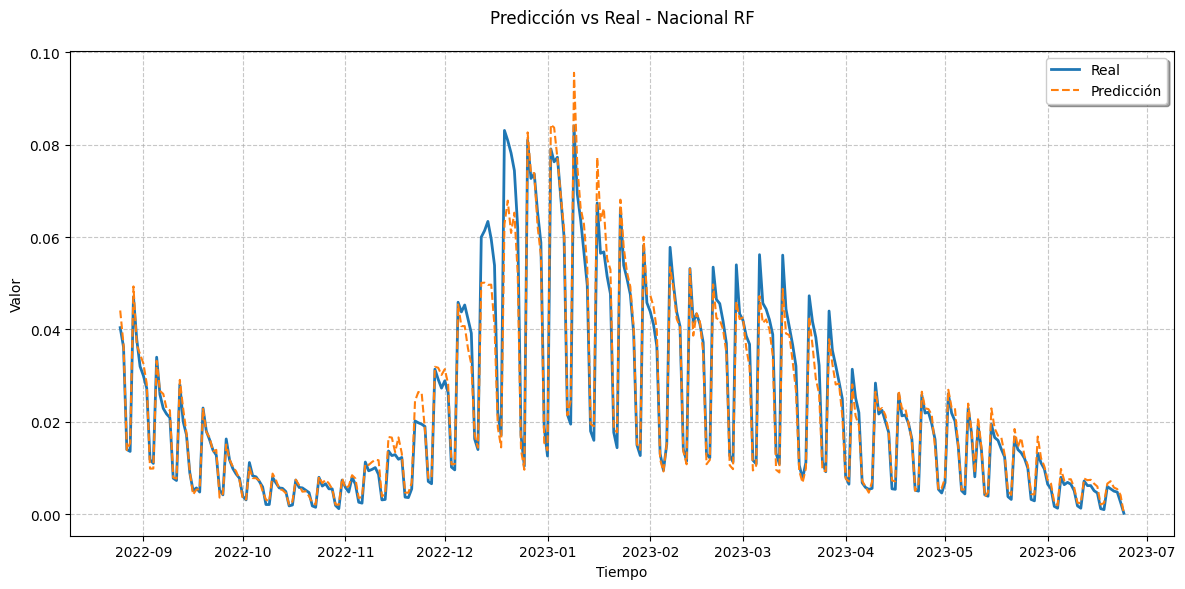

In [23]:
#Grafica de la predicción vs real RF
plt.figure(figsize=(12, 6))  
plt.plot(Y_test.index, Y_test.values, label="Real", linewidth=2)  
plt.plot(pred_test_df_rf.index, pred_test_df_rf.values, label="Predicción", linestyle="--")  
plt.title("Predicción vs Real - Nacional RF", fontsize=12, pad=20)
plt.xlabel("Tiempo", fontsize=10)
plt.ylabel("Valor", fontsize=10)
plt.legend(frameon=True, fancybox=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [24]:
# Support Vector Machine
svm_regr = svm.SVR()
param_search_svm_regr = {
    'kernel': ['linear'],# , 'poly', 'rbf', 'sigmoid'
    'degree': [2],  # 3, 4, 5, 6
    'C': [0.001, 0.1, 1, 10, 100], # Puedo probar con [0.001, 0.01, 0.1, 1]
    'gamma': ['scale', 'auto'],
    'epsilon': [0.1, 0.2, 0.5, 1],
}
# Puedo agregar: 'estimator__gamma': ['scale', 'auto'], # Puedo probar con [0.001, 0.01, 0.1, 1]
# Puedo agregar: 'estimator__epsilon': [0.1, 0.2, 0.5, 1]

# Utilizo GridSearchCV para encontrar los mejores parámetros
# Definir X (característica) y y (objetivo)
X = train_data[['P. Comp. 1', 'P. Comp. 2', 'P. Comp. 3']]
y = train_data[['Nacional']]

grid_search_svm = GridSearchCV(estimator=svm_regr, param_grid=param_search_svm_regr, n_jobs=-1, cv=5, verbose=1)
grid_search_svm.fit(X, y)  # Entreno el modelo con los componentes principales como característica y la columna 'Nacional' como objetivo
best_params_svm = grid_search_svm.best_params_

print("==========================================================")
print("Mejores parámetros para Support Vector Machine Regressor:")
print(best_params_svm)
print("----------------------------------------------------------")

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Mejores parámetros para Support Vector Machine Regressor:
{'C': 0.001, 'degree': 2, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
----------------------------------------------------------


In [25]:
svm_optimo = grid_search_svm.best_estimator_
# === Ajustar el modelo SVM con los datos de entrenamiento ===
svm_optimo.fit(X_train, Y_train)

# === Predicciones ===
train_pred_svm = svm_optimo.predict(X_train)  # Predecir 'Nacional' para train
test_pred_svm = svm_optimo.predict(X_test)    # Predecir 'Nacional' para test

# === Convertir a DataFrames para análisis ===
pred_train_df_svm = pd.DataFrame(train_pred_svm, columns=["Nacional"], index=X_train.index)
pred_test_df_svm = pd.DataFrame(test_pred_svm, columns=["Nacional"], index=X_test.index)

pred_train_df_svm.columns = ["Nacional"]
pred_test_df_svm.columns = ["Nacional"]

def evaluacion_metricas(true_df, pred_df):
    """
    Calculate various regression metrics comparing true and predicted values.
    
    Parameters:
    -----------
    true_df : pandas.DataFrame
        DataFrame containing actual values with 'Nacional' column
    pred_df : pandas.DataFrame
        DataFrame containing predicted values with 'Nacional' column
    
    Returns:
    --------
    pandas.DataFrame
        DataFrame containing calculated metrics
    """
    # Initialize metrics dictionary
    metrics_dict = {}
    
    # Get sample size and number of predictors
    n = len(true_df["Nacional"])
    k = 1  # number of predictors
    
    # Calculate basic error metrics
    mse = mean_squared_error(true_df["Nacional"], pred_df["Nacional"])
    mae = mean_absolute_error(true_df["Nacional"], pred_df["Nacional"])
    mape = mean_absolute_percentage_error(true_df["Nacional"], pred_df["Nacional"])
    r2 = r2_score(true_df["Nacional"], pred_df["Nacional"])
    rmse = mse ** 0.5
    
    # Calculate information criteria
    if mse > 0:
        log_likelihood = -n / 2 * np.log(2 * np.pi * mse) - n / 2
        aic = 2 * k - 2 * log_likelihood
        bic = np.log(n) * k - 2 * log_likelihood
    else:
        aic = np.nan
        bic = np.nan
    
    # Calculate Amemiya's Prediction Criterion
    apc = (1 + (k / n)) * mse
    
    # Store all metrics in dictionary
    metrics_dict["Nacional"] = {
        "MSE": mse,
        "MAE": mae,
        "MAPE": mape,
        "R2": r2,
        "RMSE": rmse,
        "AIC": aic,
        "APC": apc,
        "BIC": bic
    }
    
    return pd.DataFrame(metrics_dict).T
# Usar train_data[["Nacional"]] y test_data[["Nacional"]] para las métricas
train_metrics_svm = evaluacion_metricas(train_data[["Nacional"]], pred_train_df_svm)
test_metrics_svm = evaluacion_metricas(test_data[["Nacional"]], pred_test_df_svm)

print("\n Métrica - Train Nacional:")
print(train_metrics_svm)
print("\n Métrica - Test Nacional:")
print(test_metrics_svm)


 Métrica - Train Nacional:
               MSE       MAE          MAPE  ...          AIC       APC          BIC
Nacional  0.007251  0.073868  2.493890e+12  ... -1900.886407  0.007259 -1896.071864

[1 rows x 8 columns]

 Métrica - Test Nacional:
               MSE       MAE       MAPE  ...         AIC       APC         BIC
Nacional  0.008115  0.089438  12.761831  ... -598.737035  0.008142 -595.020007

[1 rows x 8 columns]


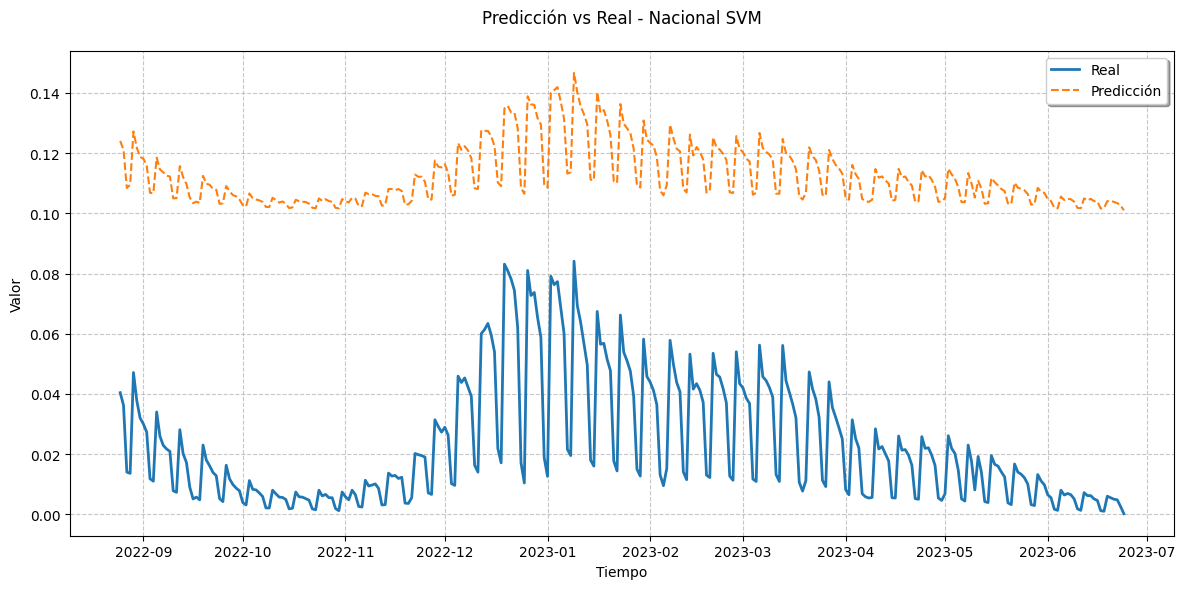

In [26]:
#Grafica de la predicción vs real SVM
plt.figure(figsize=(12, 6))  
plt.plot(Y_test.index, Y_test.values, label="Real", linewidth=2)  
plt.plot(pred_test_df_svm.index, pred_test_df_svm.values, label="Predicción", linestyle="--")  
plt.title("Predicción vs Real - Nacional SVM", fontsize=12, pad=20)
plt.xlabel("Tiempo", fontsize=10)
plt.ylabel("Valor", fontsize=10)
plt.legend(frameon=True, fancybox=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [34]:
# X, y = make_regression(n_samples=200, n_features=20, random_state=1)
# X_train, X_test, y_train, y_test = train_test_split(X, y,
#               
#'n_samples': [100, 300, 500],# Puedo probar con [100, 200, 300, 400, 500]
# 'n_features': [10, 20, 30],  # 3, 4, 5, 6                                     random_state=1)
#regr = MLPRegressor(random_state=1, max_iter=2000, tol=0.1)
#regr.fit(X_train, y_train)
#MLPRegressor(max_iter=2000, random_state=1, tol=0.1)
#regr.predict(X_test[:2])
#array([  28.98, -291])
#regr.score(X_test, y_test)
#0.98

In [35]:
# Multi-layer Perceptron Regressor
mlp_regr = MLPRegressor()
param_search_mlp_regr = {
    'random_state': [1, None],  # Fijo el estado aleatorio para reproducibilidad
    'max_iter': [1000, 2000, 3000],  # Puedo probar con [1000, 2000, 3000, 4000]
    'tol': [0.01, 0.1, 0.2],  # Puedo probar con [0.01, 0.05, 0.1, 0.2]
    'hidden_layer_sizes': [(50,), (100,), (150,), (200,)],  # Puedo probar con [(50,), (100,), (150,), (200,), (250,)]
    'learning_rate': ['constant', 'invscaling', 'adaptive'],  # Puedo probar con ['constant', 'invscaling', 'adaptive']
}

# Utilizo GridSearchCV para encontrar los mejores parámetros
# Definir X (característica) y y (objetivo)
X = train_data[['P. Comp. 1', 'P. Comp. 2', 'P. Comp. 3']]
y = train_data[['Nacional']]

grid_search_mlp = GridSearchCV(estimator=mlp_regr, param_grid=param_search_mlp_regr, n_jobs=-1, cv=5, verbose=1)
grid_search_mlp.fit(X, y)  # Entreno el modelo con los componentes principales como característica y la columna 'Nacional' como objetivo
best_params_mlp = grid_search_mlp.best_params_

print("==========================================================")
print("Mejores parámetros para Multi-layer Perceptron Regressor:")
print(best_params_mlp)
print("----------------------------------------------------------")

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Mejores parámetros para Multi-layer Perceptron Regressor:
{'hidden_layer_sizes': (100,), 'learning_rate': 'invscaling', 'max_iter': 1000, 'random_state': None, 'tol': 0.01}
----------------------------------------------------------


In [36]:
mlp_optimo = grid_search_mlp.best_estimator_
# === Ajustar el modelo SVM con los datos de entrenamiento ===
mlp_optimo.fit(X_train, Y_train)

# === Predicciones ===
train_pred_mlp = mlp_optimo.predict(X_train)  # Predecir 'Nacional' para train
test_pred_mlp = mlp_optimo.predict(X_test)    # Predecir 'Nacional' para test

# === Convertir a DataFrames para análisis ===
pred_train_df_mlp = pd.DataFrame(train_pred_mlp, columns=["Nacional"], index=X_train.index)
pred_test_df_mlp = pd.DataFrame(test_pred_mlp, columns=["Nacional"], index=X_test.index)

pred_train_df_mlp.columns = ["Nacional"]
pred_test_df_mlp.columns = ["Nacional"]

def evaluacion_metricas(true_df, pred_df):
    """
    Calculate various regression metrics comparing true and predicted values.
    
    Parameters:
    -----------
    true_df : pandas.DataFrame
        DataFrame containing actual values with 'Nacional' column
    pred_df : pandas.DataFrame
        DataFrame containing predicted values with 'Nacional' column
    
    Returns:
    --------
    pandas.DataFrame
        DataFrame containing calculated metrics
    """
    # Initialize metrics dictionary
    metrics_dict = {}
    
    # Get sample size and number of predictors
    n = len(true_df["Nacional"])
    k = 1  # number of predictors
    
    # Calculate basic error metrics
    mse = mean_squared_error(true_df["Nacional"], pred_df["Nacional"])
    mae = mean_absolute_error(true_df["Nacional"], pred_df["Nacional"])
    mape = mean_absolute_percentage_error(true_df["Nacional"], pred_df["Nacional"])
    r2 = r2_score(true_df["Nacional"], pred_df["Nacional"])
    rmse = mse ** 0.5
    
    # Calculate information criteria
    if mse > 0:
        log_likelihood = -n / 2 * np.log(2 * np.pi * mse) - n / 2
        aic = 2 * k - 2 * log_likelihood
        bic = np.log(n) * k - 2 * log_likelihood
    else:
        aic = np.nan
        bic = np.nan
    
    # Calculate Amemiya's Prediction Criterion
    apc = (1 + (k / n)) * mse
    
    # Store all metrics in dictionary
    metrics_dict["Nacional"] = {
        "MSE": mse,
        "MAE": mae,
        "MAPE": mape,
        "R2": r2,
        "RMSE": rmse,
        "AIC": aic,
        "APC": apc,
        "BIC": bic
    }
    
    return pd.DataFrame(metrics_dict).T
# Usar train_data[["Nacional"]] y test_data[["Nacional"]] para las métricas
train_metrics_mlp = evaluacion_metricas(train_data[["Nacional"]], pred_train_df_mlp)
test_metrics_mlp = evaluacion_metricas(test_data[["Nacional"]], pred_test_df_mlp)

print("\n Métrica - Train Nacional:")
print(train_metrics_mlp)
print("\n Métrica - Test Nacional:")
print(test_metrics_mlp)


 Métrica - Train Nacional:
               MSE       MAE          MAPE  ...          AIC       APC          BIC
Nacional  0.000314  0.010329  1.690918e+10  ... -4761.799446  0.000314 -4756.984903

[1 rows x 8 columns]

 Métrica - Test Nacional:
              MSE       MAE      MAPE  ...          AIC      APC          BIC
Nacional  0.00002  0.002543  0.129316  ... -2430.746894  0.00002 -2427.029866

[1 rows x 8 columns]


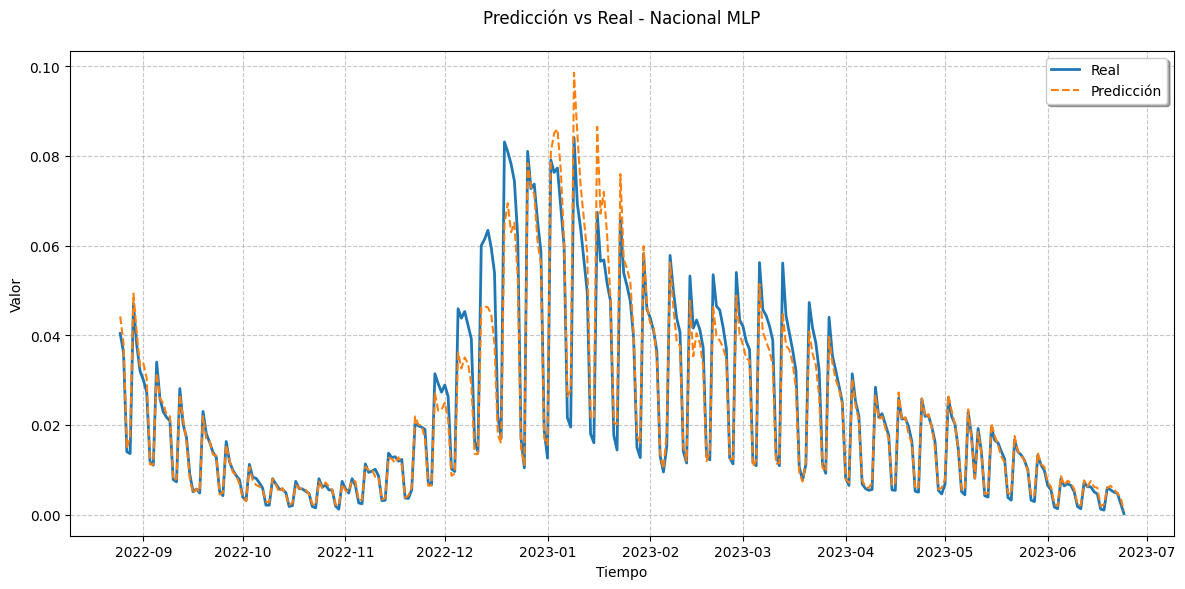

In [37]:
#Grafica de la predicción vs real MLP
plt.figure(figsize=(12, 6))  
plt.plot(Y_test.index, Y_test.values, label="Real", linewidth=2)  
plt.plot(pred_test_df_mlp.index, pred_test_df_mlp.values, label="Predicción", linestyle="--")  
plt.title("Predicción vs Real - Nacional MLP", fontsize=12, pad=20)
plt.xlabel("Tiempo", fontsize=10)
plt.ylabel("Valor", fontsize=10)
plt.legend(frameon=True, fancybox=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()